In [2]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
from pathlib import Path

In [3]:
model_name_it = "Efficient_net_B0_it.h5"

In [4]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [6]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [7]:
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [70]:
gen_params = {"rotation_range":40,\
              "width_shift_range":0.2,\
              "height_shift_range":0.2, \
              "shear_range":0.4, \
              "zoom_range":0.3}

Train and validation generators

In [71]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [72]:
bs = 32 # batch size

In [73]:
path = Path("D:/Mestrado/term-project/dataset")

In [74]:
img_height = 224
img_width = 224

In [75]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]
              

In [76]:
print("Num classes  = {}".format(len(classes_names)))

Num classes  = 52


In [77]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    classes = classes_names) # set as training data

Found 1477 images belonging to 52 classes.


In [78]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    classes = classes_names) # set as validation data

Found 334 images belonging to 52 classes.


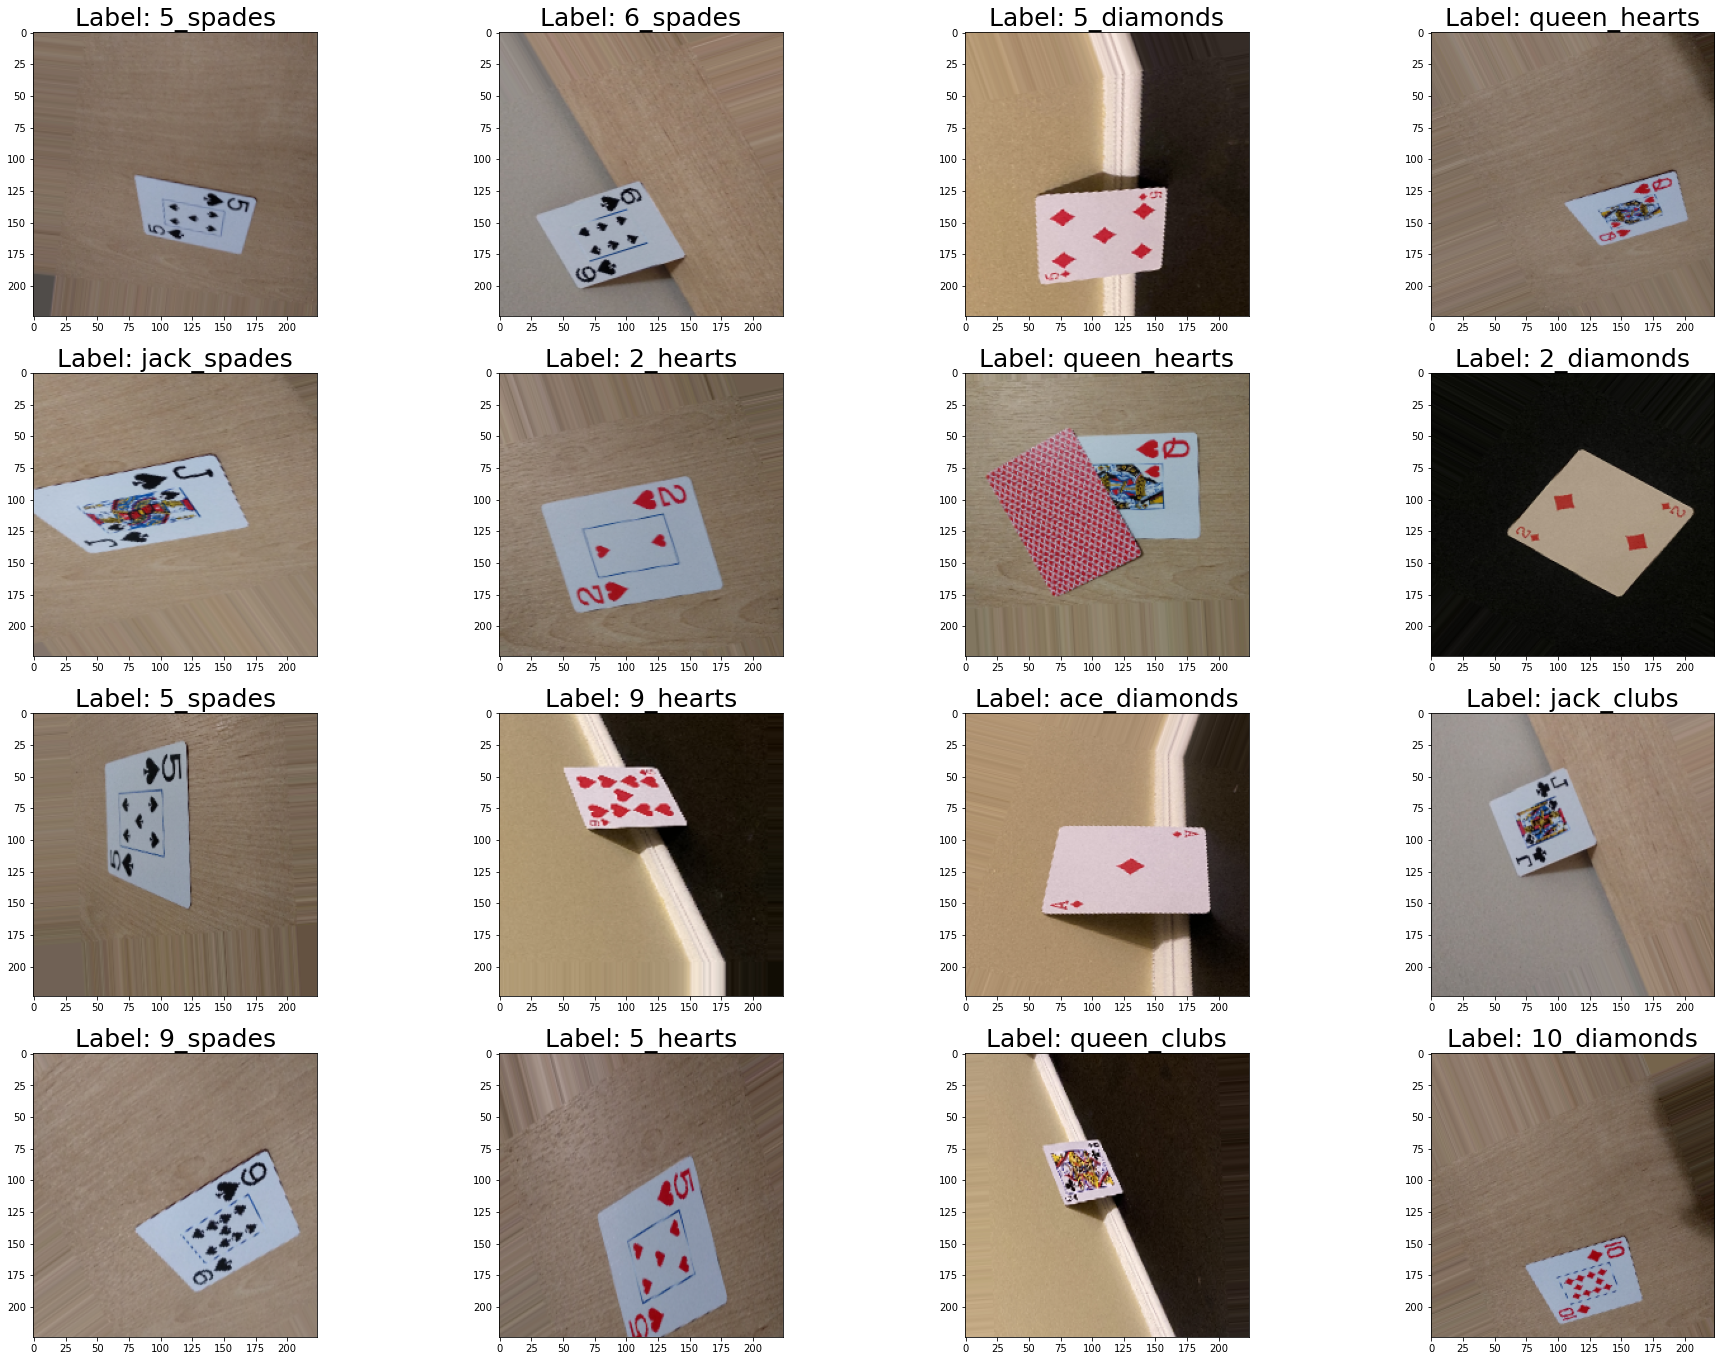

In [79]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = validation_generator.__getitem__(0)
for ii in range(int(bs/2)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [80]:
# Defining the model

In [81]:
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', 
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [82]:
base_model.trainable = False

In [83]:
x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x3 = tf.keras.layers.Flatten()(x2)
out = tf.keras.layers.Dense(len(classes_names),activation = 'softmax')(x3)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

In [84]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 52)                66612     
                                                                 
Total params: 4,116,183
Trainable params: 66,612
Non-trainable params: 4,049,571
_____________________

In [85]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [early_stop, monitor_it, lr_schedule])

Epoch 1/1000
47/47 [==============================] - 90s 2s/step - loss: 3.9978 - accuracy: 0.0169 - val_loss: 3.9771 - val_accuracy: 0.0269 - lr: 1.0000e-04
Epoch 2/1000
47/47 [==============================] - 83s 2s/step - loss: 3.8464 - accuracy: 0.0454 - val_loss: 3.9051 - val_accuracy: 0.0539 - lr: 1.0000e-04
Epoch 3/1000
47/47 [==============================] - 82s 2s/step - loss: 3.7191 - accuracy: 0.1002 - val_loss: 3.8393 - val_accuracy: 0.0539 - lr: 1.0000e-04
Epoch 4/1000
32/47 [===================>..........] - ETA: 16s - loss: 3.6165 - accuracy: 0.1204